# 1. Install Dependencies and Setup

In [2]:
!python -m pip install --upgrade pip

  Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [3]:
!pip install tensorflow

  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl.metadata (3.6 kB)
  Using cached tensorflow_intel-2.15.0-cp39-cp39-win_amd64.whl.metadata (5.1 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-win_amd64.whl.metadata (20 kB)
  Using cached numpy-1.26.2-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.25.1-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached grpcio-1.60.0-cp39-cp39-win_amd64.whl.metadata (4.2 kB)
  Using cached tensorboard-2.15.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl

In [5]:
!pip install opencv-python matplotlib

  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/159.4 kB ? eta -:--:--
     -------------------------------------- 159.4/159.4 kB 4.8 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached Pillow-10.1.0-cp39-cp39-win_amd64.whl.metadata (9.6 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.1.1-py3-none-any.whl.metadata (4.1 kB)
Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl (38.1 MB)
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ------ --------------------------------- 1.3/7.6 MB 27.5 MB/s eta 0:00:01
   ------------- -------------------------- 2.5/7.6 MB 32.4 MB/s eta 0:00:01
   -------------------- ------------------- 3.8/7.6 MB 30.6 MB/s eta 0:00:01
   ---------------------- ----------------- 4.3

In [6]:
!pip list

Package                      Version
---------------------------- ----------
absl-py                      2.0.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.2
certifi                      2023.11.17
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
flatbuffers                  23.5.26
fonttools                    4.46.0
gast                         0.5.4
google-auth                  2.25.2
google-auth-oauthlib         1.2.0
google-pasta                 0.2.0
grpcio                       1.60.0
h5py                         3.10.0
idna                         3.6
importlib-metadata           7.0.0
importlib-resources          6.1.1
ipykernel                    6.27.1
ip

In [7]:
import tensorflow as tf
import os

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [10]:
import cv2
import imghdr

In [11]:
data_dir = 'data' 

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

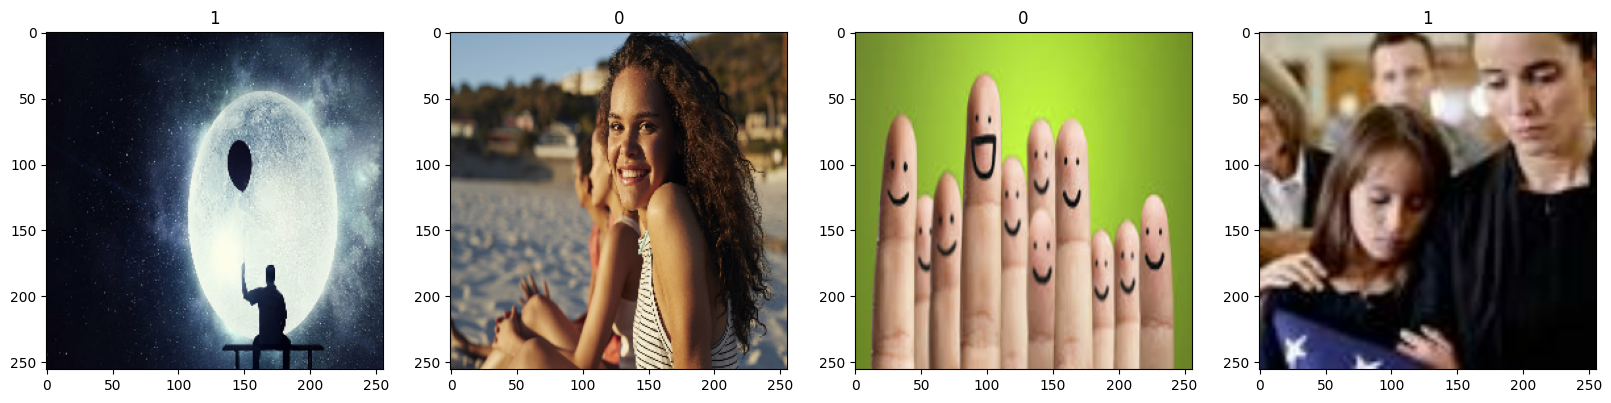

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.8435049 , 0.83958334, 0.82389706],
          [0.7693321 , 0.76541054, 0.74972427],
          [0.8151808 , 0.8112592 , 0.79557294],
          ...,
          [0.65580577, 0.6518842 , 0.6361979 ],
          [0.7868413 , 0.7829197 , 0.76723343],
          [0.7679075 , 0.76398593, 0.74829966]],
 
         [[0.81308246, 0.8091609 , 0.7934746 ],
          [0.7804075 , 0.7764859 , 0.76079965],
          [0.81432784, 0.81040627, 0.79472   ],
          ...,
          [0.6722369 , 0.66831535, 0.6526291 ],
          [0.7754287 , 0.77150714, 0.7558209 ],
          [0.7604225 , 0.75650096, 0.7408147 ]],
 
         [[0.77562505, 0.7717035 , 0.7560172 ],
          [0.79433244, 0.7904109 , 0.7747246 ],
          [0.81433153, 0.81040996, 0.7947237 ],
          ...,
          [0.68921304, 0.68529147, 0.6696052 ],
          [0.7567718 , 0.75285023, 0.73716396],
          [0.74962735, 0.7457058 , 0.7300195 ]],
 
         ...,
 
         [[0.9724193 , 0.96849775, 0.9528115 ],
          [0.94128

# 5. Split Data

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:
train_size

7

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [24]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 [==============================] - 10s 957ms/step - loss: 1.2663 - accuracy: 0.5089 - val_loss: 0.7146 - val_accuracy: 0.5469
Epoch 2/20
7/7 [==============================] - 6s 674ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6946 - val_accuracy: 0.4375
Epoch 3/20
7/7 [==============================] - 6s 632ms/step - loss: 0.6843 - accuracy: 0.5491 - val_loss: 0.6534 - val_accuracy: 0.6875
Epoch 4/20
7/7 [==============================] - 5s 545ms/step - loss: 0.6201 - accuracy: 0.7545 - val_loss: 0.5459 - val_accuracy: 0.7812
Epoch 5/20
7/7 [==============================] - 5s 580ms/step - loss: 0.5381 - accuracy: 0.7768 - val_loss: 0.3964 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 6s 592ms/step - loss: 0.4632 - accuracy: 0.7857 - val_loss: 0.4646 - val_accuracy: 0.7969
Epoch 7/20
7/7 [==============================] - 5s 620ms/step - loss: 0.4161 - accuracy: 0.8214 - val_loss: 0.4604 - val_accuracy: 0.7188
Epoch 8/20
7/7 [=

# 8. Plot Performance

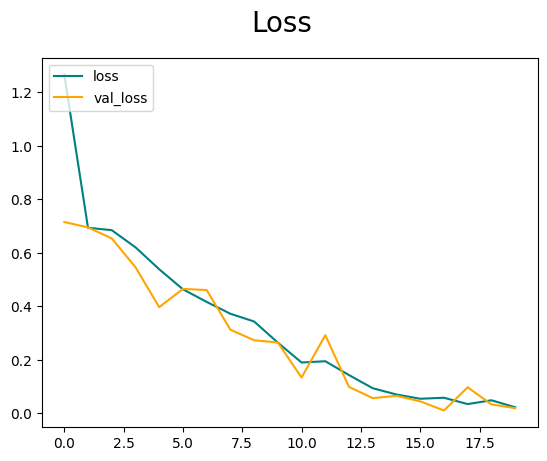

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

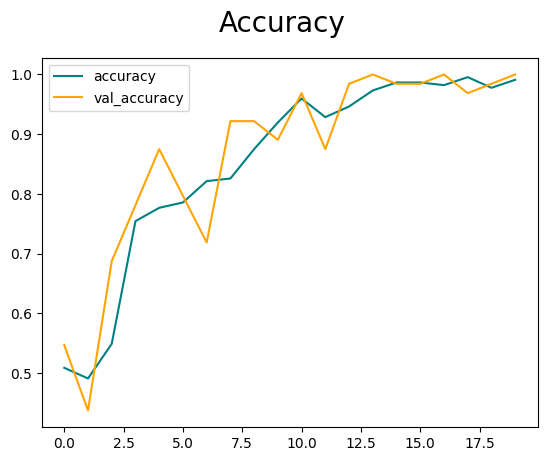

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 310ms/step


In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [39]:
import cv2

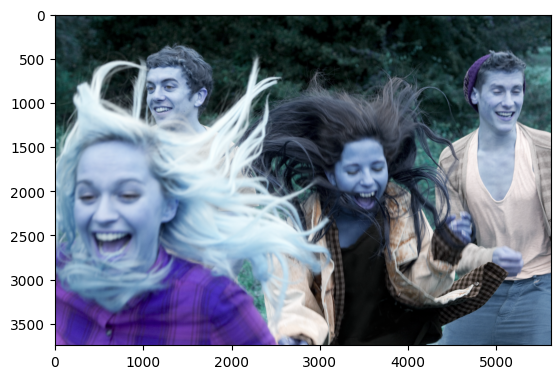

In [40]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

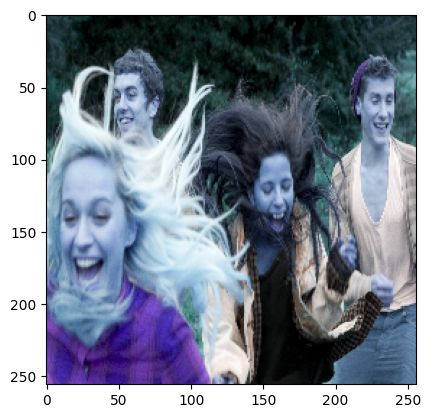

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 45ms/step


In [43]:
yhat

array([[0.01015751]], dtype=float32)

In [44]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model.save(os.path.join('models','classifier.h5'))

c:\NYU\ComputerVison\FinalProject\CV-Final-Project\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
new_model = load_model('C:\NYU\ComputerVison\FinalProject\CV-Final-Project\models\imageclassifier.h5')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: malformed \N character escape (3236261073.py, line 1)

In [48]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined